# **Speech Processing Lab 9**

Rishabh Tripathi (180030036)

## **AIM**
1. To compute LP coefficients and LP residual of a given speech signal.
2. To compute the formant parameters by LP analysis.
3. To compute the excitation parameters like pitch by LP analysis.
4. To compute the normalized error curves for voiced and unvoiced segments of speech.


In [ ]:
# importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift, ifft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Speech\ Processing\ Lab/Lab\ 9

/content/drive/MyDrive/Speech Processing Lab/Lab 9


## **Theory**

Speech signal is produced by the convolution of excitation source and time varying vocal tract system components. These excitation and vocal tract components are to be separated from the available speech signal to study these components independently. For this purpose, methods based on homomorphic analysis like cepstral analysis are developed. As the cepstral analysis does the deconvolution of speech into source and system components by traversing through frequency domain, the deconvolution task becomes computational intensive process. To reduce such type of computational complexity and finding the source and system components from time domain itself, the Linear Prediction analysis is developed.

The prediction error in this method is given as:

$$e(n) = s(n) - \hat s(n)$$

$$e(n) = s(n) - \sum_{k=1}^{p} a_k s(n-k)$$

Differentiating and equating to zero, we obtain the **Yule-Walker** equation:

$$c(l, 0) = \sum_{k=1}^{p} a_k c(k, l)$$

We write it in the form,

$$\bar c = \textbf{C} \bar a$$

$$ \bar c =  \begin{bmatrix}
c(1,0)\\
c(2,0)\\
{...}\\
c(p,0)
\end{bmatrix} \quad
\textbf{C} = \begin{bmatrix}
c(1,1) & c(1,2) & {...} & c(1,p)\\
c(2,1) & c(2,2) & {...} & c(2,p)\\
{...} & {...} & {...} & {...}\\
c(p,1) & c(p,2) & {...} & c(p,p)
\end{bmatrix} \quad
\bar a =  \begin{bmatrix}
a_1\\
a_2\\
{...}\\
a_p
\end{bmatrix} \quad$$

We get the solution by inverting the covariance matrix,

$$\bar a = \textbf{C}^{-1} \bar c$$



## **Problem A**
Estimating Linear Prediction (LP) coefficients from the speech.
1. Select a frame (25 ms long) at the center of a voiced segment. Estimate the LPCs of the segment using the autocorrelation method.


In [ ]:
# Function to plot the waveform
def wave_plot(sound, time, sound_name):
    plt.figure(figsize=(15,5))
    plt.plot(time, sound)
    plt.title("Time Domain Plot of sound "+ "/" + sound_name + "/")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

In [ ]:
# Function to plot or return magnitude spectrum 
def plot_spectrum(sound, sound_name, type='lin'):
    
    # Getting the Discrete Fourier Transform of the sound
    total_len = sound.shape[0]
    audio_fft = fft(sound)/total_len

    f_array = fftfreq(total_len, 1/fs)
    
    if type == 'log':
        plt.figure(figsize=(15,5))
        plt.plot(f_array[0:total_len//2], 2*np.abs(audio_fft[0:total_len//2]))
        plt.title("Magnitude Spectrum of "+ "/" + sound_name + "/")
        plt.yscale('log')
        plt.xlim((0, 8000))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.show()

    if type == 'lin':
        plt.figure(figsize=(15,5))
        plt.plot(f_array[0:total_len//2], 2*np.abs(audio_fft[0:total_len//2]))
        plt.title("Magnitude Spectrum of "+ "/" + sound_name + "/")
        plt.xlim((0, 8000))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.show()

    if type == 'none':
        return f_array[0:total_len//2], 2*audio_fft[0:total_len//2]

In [ ]:
def autocorr(sound, plot=0, sound_name=""):
    len = sound.shape[0]
    shift = np.arange(0, len, 1)
    autocorr = np.zeros((shift.shape[0],))

    for curr_shift in shift:
        autocorr[curr_shift] = np.dot(sound[0:len-curr_shift].T,sound[curr_shift:])

    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(shift, autocorr)
        plt.title("Autocorrelation of sound "+ "/" + sound_name + "/")
        plt.xlabel('Shift')
        plt.ylabel('Autocorrelation')
        plt.show()

    else:
        return autocorr

In [ ]:
# Function to estimate the LPCs using autocorrelation method
# Levinson-Durbin Recursion
def lp_coeff(sound, sound_name, p):

    sound_acf = autocorr(sound, plot=0, sound_name=sound_name)

    energy = np.zeros((p+1, ))
    energy[0] = sound_acf[0]

    reflection_coeff = np.zeros((p+1, ))
    a = np.zeros((p+1, p+1))

    for i in range(1, p+1):

        reflection_coeff[i] = sound_acf[i] - np.dot(a[i-1][1:i], (sound_acf[1:i])[::-1])
        reflection_coeff[i] = reflection_coeff[i] / energy[i-1]

        for j in range(1, i):

            a[i][i] = reflection_coeff[i]
            a[i][j] = a[i-1][j] - reflection_coeff[i]*a[i-1][i-j]

        energy[i] = (1 - reflection_coeff[i]**2)*energy[i-1]

    return a[p][1:p+1]

In [ ]:
# Loading the audio file
audio, fs = librosa.load("speech_signal.wav", sr = 16000)
t = np.arange(0, audio.shape[0]/fs, 1/fs)

In [ ]:
# Centre time stamp of the voiced sound /ee/ is obtained using WaveSurfer
# /ee/ sound => 0.48 s

frame_size = 0.025
ee = audio[int((0.48-(frame_size/2))*fs):int((0.48+(frame_size/2))*fs)]
t_ee = np.arange(0, ee.shape[0]/fs, 1/fs)

In [ ]:
p = 12
lp_coeff_ee = lp_coeff(ee, "ee", p)
print("Estimated LPCs of the voiced sound /ee/ for p = 12:\n", lp_coeff_ee)

Estimated LPCs of the voiced sound /ee/ for p = 12:
 [-5.92698575  4.99649375  0.69110745  0.49146443  3.50758723 -1.15094208
 -0.76927442  3.74609342 -2.20194443 -4.73755864  1.16020678  0.27154653]


## **Problem B**
Computing LP residual
1. Using the computed LPCs, derive the LP residual signal.


In [ ]:
# using LPCs deriving the filter H
A = np.insert(-1*lp_coeff_ee, 0, 1)

H = fft(A, len(ee))
H = 1/H
f_array = fftfreq(len(ee), 1/fs)

In [ ]:
# DERIVING RESIDUAL SIGNAL

# We convolve the original signal with the A vector consisting of LPCs
residual = np.convolve(ee, A)
residual = residual[0:-len(A)+1]
t_res = np.arange(0, residual.shape[0]/fs, 1/fs)

# We can also use the frequency domain to get the residual signal
# X = fft(ee, len(ee))
# residual = ifft(np.multiply(X, H))
# residual = np.real(residual)
# t_res = np.arange(0, residual.shape[0]/fs, 1/fs)

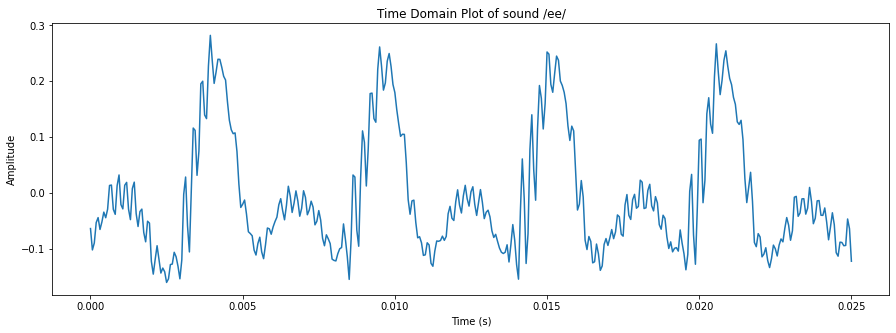

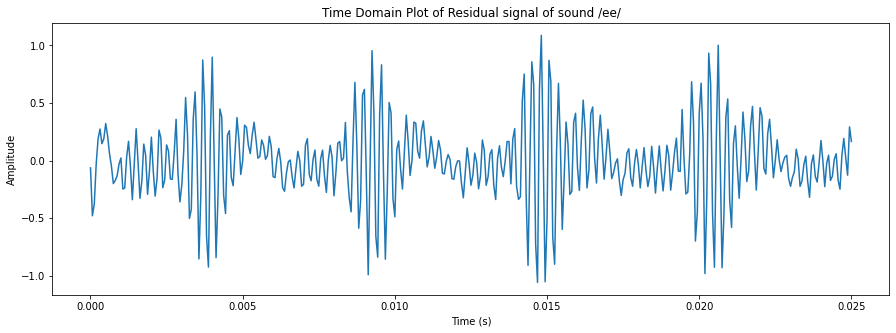

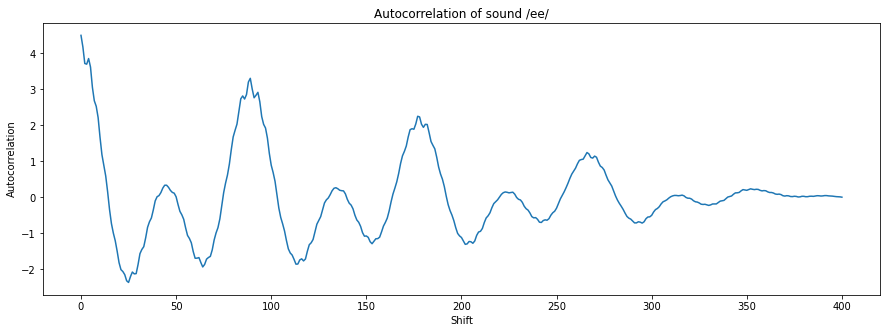

In [ ]:
wave_plot(ee, t_ee, "ee")

plt.figure(figsize=(15,5))
plt.plot(t_res, np.real(residual))
plt.title("Time Domain Plot of Residual signal of sound /ee/")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

autocorr(ee, sound_name="ee", plot=1)

## **Problem C**
Pitch estimation from LP residual:
1. Estimate the pitch from the estimated LP residual using autocorrelation.


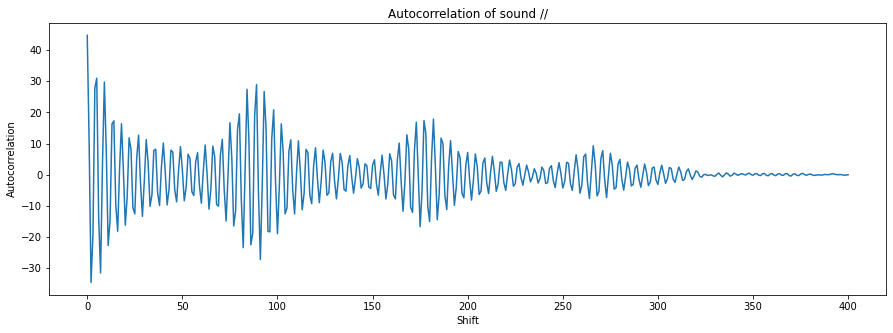

In [ ]:
# performing the autocorrelation of LP residual
res_autocorr = autocorr(residual, sound_name="")
autocorr(residual, sound_name="", plot=1)

In [ ]:
offset = 20
truncated = res_autocorr[offset:-1]
index = np.argmax(truncated)

pitch = fs/(offset+index)
 
print("Estimated pitch =", pitch, "Hz")

Estimated pitch = 179.77528089887642 Hz


## **Problem D**
Formant estimation from LP spectrum:
1. Explain, step by step, the procedure of computing the LP spectrum from LPCs.
2. Demonstrate the same on the voiced frame selected above.


### **Procedure**
1. We first calculate the LP coefficients using the autocorrelation method.
2. Then we obtain the frequency response of the filter using the LPCs.
3. We can plot this filter H to get the LP spectrum.

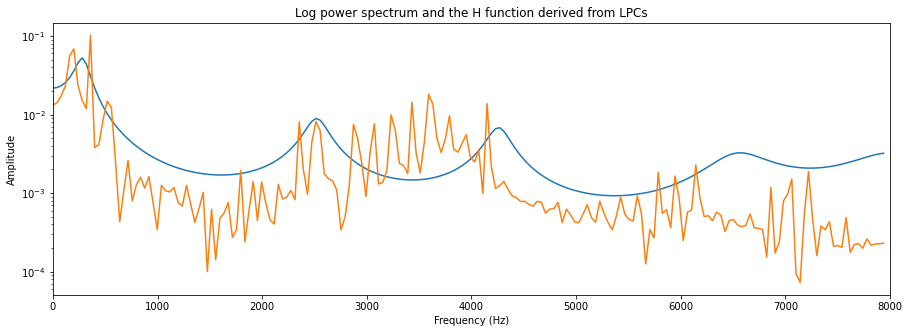

In [ ]:
f, spectrum = plot_spectrum(ee, "ee",type='none')

plt.figure(figsize=(15,5))
plt.plot(f_array[0:len(ee)//2], 0.02*np.abs((H[0:len(ee)//2])))
plt.plot(f, np.abs(spectrum))
plt.title("Log power spectrum and the H function derived from LPCs")
plt.yscale('log')
plt.xlim((0, 8000))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

## **Problem E**
Normalized Error
1. Select the 25ms frame at the center of the voiced and unvoiced frame respectively. Compute the normalized LP residual error as a function of the order of LP prediction. Plot normalized error curve against the prediction order for both voiced and unvoiced frames
2. Comment upon the choice of optimal prediction order for the  segments. 


In [375]:
# Centre time stamp of the voiced sound /ee/ and /ss/ is obtained using WaveSurfer
# /ee/ sound => 0.48 s
# /ss/ sound => 0.97 s

frame_size = 0.025
ee = audio[int((0.48-(frame_size/2))*fs):int((0.48+(frame_size/2))*fs)]
t_ee = np.arange(0, ee.shape[0]/fs, 1/fs)
ss = audio[int((0.97-(frame_size/2))*fs):int((0.97+(frame_size/2))*fs)]
t_ss = np.arange(0, ss.shape[0]/fs, 1/fs)

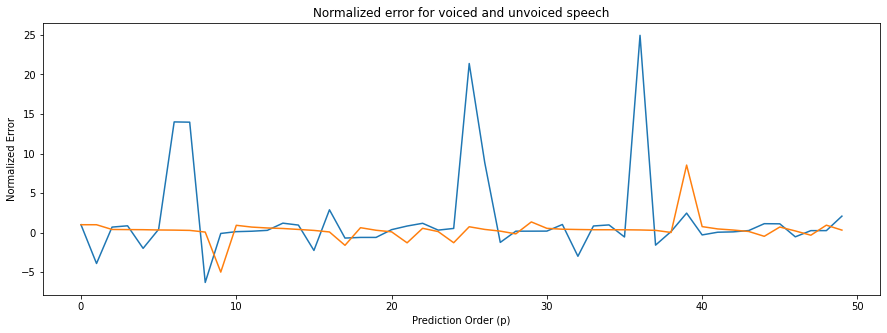

In [378]:
p_values = 50
error_ee = np.zeros((p_values,))
error_ss = np.zeros((p_values,))

for p in range(1, p_values+1):

    ee_acf = autocorr(ee, plot=0, sound_name="")
    lp_coeff_ee = lp_coeff(ee, "ee", p)

    temp_ee = np.dot(lp_coeff_ee, ee_acf[1:p+1])
    error_ee[p-1] = (ee_acf[0] - temp_ee)/ee_acf[0]

    ss_acf = autocorr(ss, plot=0, sound_name="")
    lp_coeff_ss = lp_coeff(ss, "ss", p)

    temp_ss = np.dot(lp_coeff_ss, ss_acf[1:p+1])
    error_ss[p-1] = (ss_acf[0] - temp_ss)/ss_acf[0]

plt.figure(figsize=(15,5))
plt.plot(error_ee)
plt.plot(error_ss)
plt.title("Normalized error for voiced and unvoiced speech")
plt.xlabel('Prediction Order (p)')
plt.ylabel('Normalized Error')
plt.show()